In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [29]:
import os
import math
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, HTML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pymc

In [42]:
import theano.tensor as tt

In [4]:
DATA_DIR = os.path.join(os.getcwd(), '../data/')
CHART_DIR = os.path.join(os.getcwd(), '../data/charts/')

In [8]:
data_file = DATA_DIR + 'epl_2014.txt'
df = pd.read_csv(data_file, sep='\t', index_col=0,na_values='—')
df.head()

,ARS,AST,CAR,CHE,CRY,EVE,FUL,HUL,LIV,MCI,MUN,NEW,NOR,SOU,STK,SUN,SWA,TOT,WBA,WHU
Home \ Away,,,,,,,,,,,,,,,,,,,,
Arsenal,NaN,1–3,2–0,0–0,2–0,1–1,2–0,2–0,2–0,1–1,0–0,3–0,4–1,2–0,3–1,4–1,2–2,1–0,1–0,3–1
Aston Villa,1–2,NaN,2–0,1–0,0–1,0–2,1–2,3–1,0–1,3–2,0–3,1–2,4–1,0–0,1–4,0–0,1–1,0–2,4–3,0–2
Cardiff City,0–3,0–0,NaN,1–2,0–3,0–0,3–1,0–4,3–6,3–2,2–2,1–2,2–1,0–3,1–1,2–2,1–0,0–1,1–0,0–2
Chelsea,6–0,2–1,4–1,NaN,2–1,1–0,2–0,2–0,2–1,2–1,3–1,3–0,0–0,3–1,3–0,1–2,1–0,4–0,2–2,0–0
Crystal Palace,0–2,1–0,2–0,1–0,NaN,0–0,1–4,1–0,3–3,0–2,0–2,0–3,1–1,0–1,1–0,3–1,0–2,0–1,3–1,1–0


In [10]:
df.index

Index(['Arsenal', 'Aston Villa', 'Cardiff City', 'Chelsea', 'Crystal Palace',
       'Everton', 'Fulham', 'Hull City', 'Liverpool', 'Manchester City',
       'Manchester United', 'Newcastle United', 'Norwich City', 'Southampton',
       'Stoke City', 'Sunderland', 'Swansea City', 'Tottenham Hotspur',
       'West Bromwich Albion', 'West Ham United'],
      dtype='object', name='Home \ Away')

In [20]:
df.index = df.columns
rows = []
for i in df.index:
    for c in df.columns:
        if i == c: continue
        score = df.loc[i, c] #df.ix[i, c]
        score = [int(row) for row in score.split('–')]
        rows.append([i, c, score[0], score[1]])
df = pd.DataFrame(rows, columns = ['home', 'away', 'home_score', 'away_score'])
df.head()

,home,away,home_score,away_score
0,ARS,AST,1,3
1,ARS,CAR,2,0
2,ARS,CHE,0,0
3,ARS,CRY,2,0
4,ARS,EVE,1,1


In [21]:
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

,team,i
0,ARS,0
1,AST,1
2,CAR,2
3,CHE,3
4,CRY,4


In [22]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home,away,home_score,away_score,i_home,i_away
0,ARS,AST,1,3,0,1
1,ARS,CAR,2,0,0,2
2,ARS,CHE,0,0,0,3
3,ARS,CRY,2,0,0,4
4,ARS,EVE,1,1,0,5


In [23]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

In [24]:
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

### Model

In [ ]:
#hyperpriors
with pymc.Model():
    home = pymc.Normal('home', 0, .0001, value=0)
    tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
    tau_def = pymc.Gamma('tau_def', .1, .1, value=10)
    intercept = pymc.Normal('intercept', 0, .0001, value=0)

#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

In [48]:
#hyperpriors
with pymc.Model() as model:
    home = pymc.Normal('home', 0, .0001)
    tau_att = pymc.Gamma('tau_att', .1, .1)
    tau_def = pymc.Gamma('tau_def', .1, .1)
    intercept = pymc.Normal('intercept', 0, .0001)

    #team-specific parameters
    atts_star = pymc.Normal("atts_star", 
                            mu=0, 
                            tau=tau_att, 
                            shape=num_teams)
    defs_star = pymc.Normal("defs_star", 
                            mu=0, 
                            tau=tau_def, 
                            shape=num_teams) 
    
    atts = pymc.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pymc.Deterministic("defs", atts_star - tt.mean(atts_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    home_goals = pymc.Poisson("home_goals", mu=home_theta, observed=observed_home_goals)
    away_goals = pymc.Poisson("away_goals", mu=away_theta, observed=observed_away_goals)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defs_star, atts_star, intercept, tau_def, tau_att, home]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 111 seconds.
The acceptance probability does not match the target. It is 0.9795408373005153, but should be close to 0.8. Try to increase the number of tuning steps.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3778126204859412, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


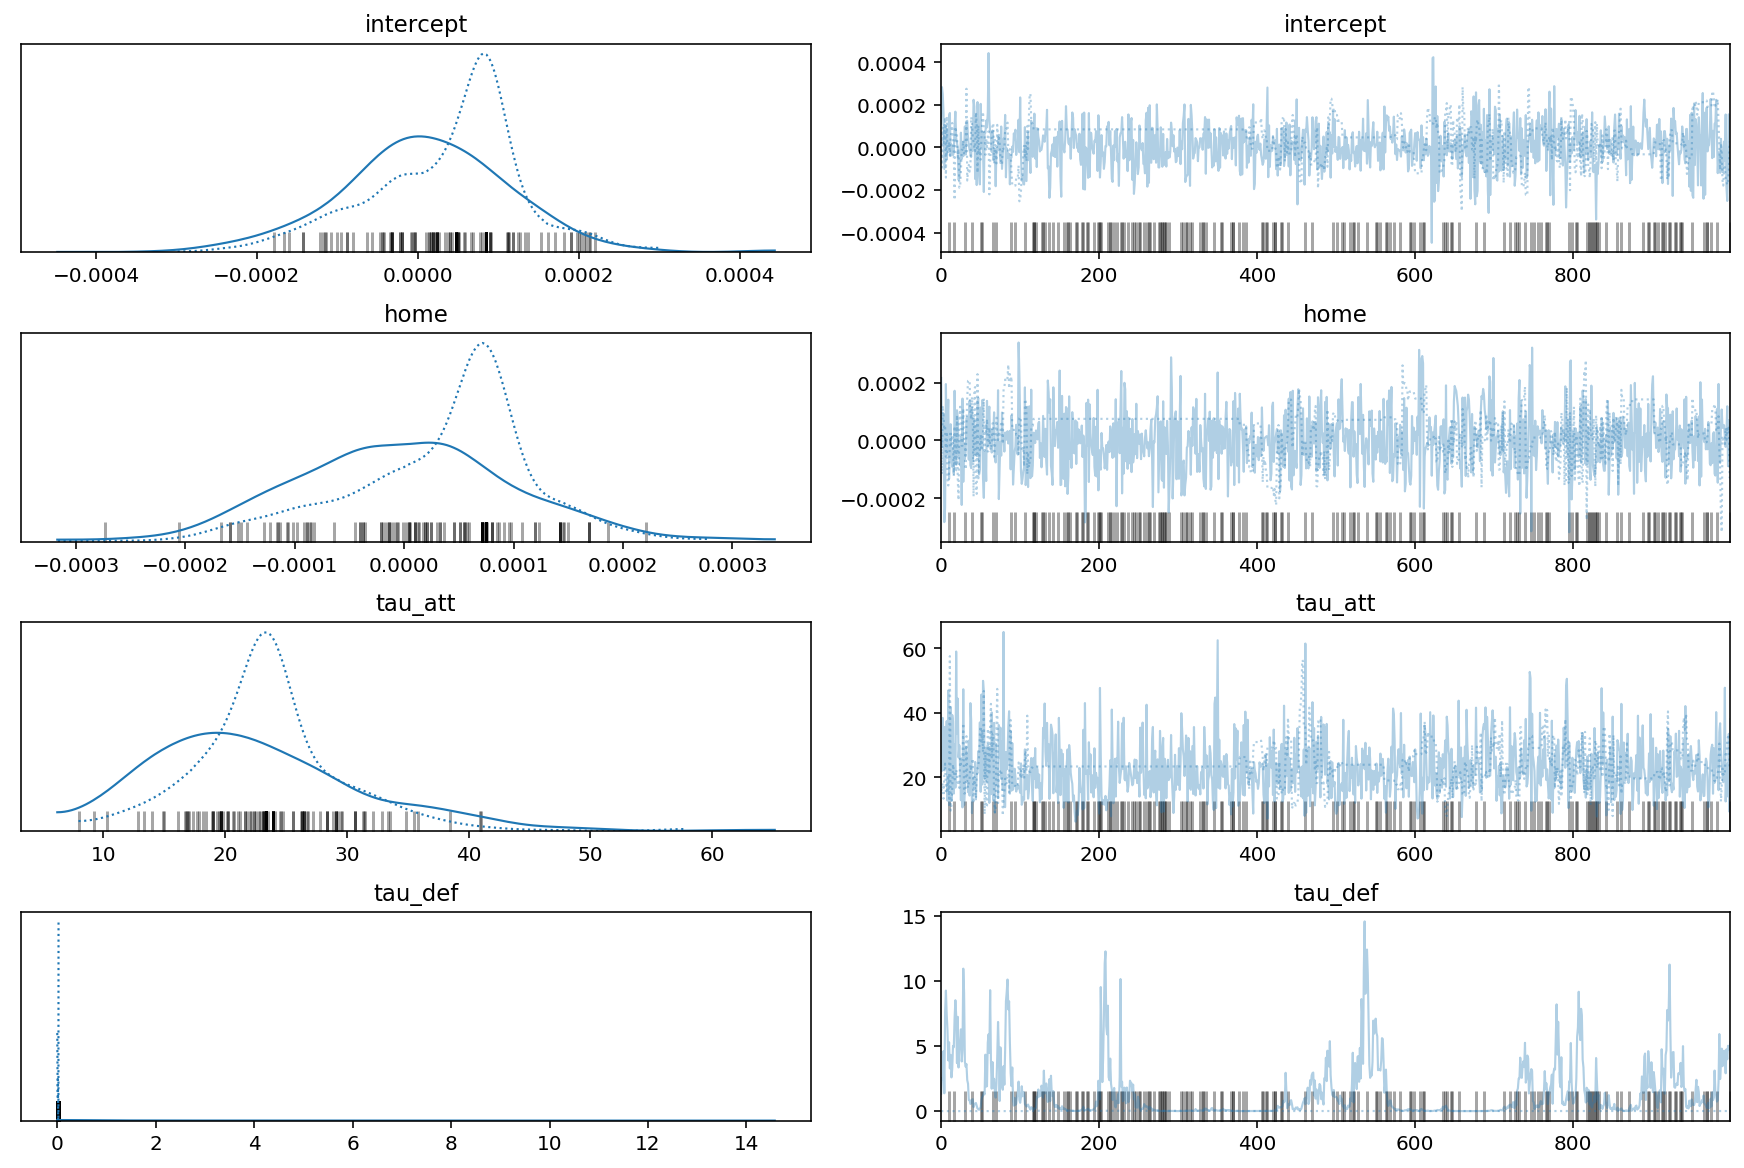

In [51]:
with model:
    trace = pymc.sample(1000, tune=1000, cores=None)

pymc.traceplot(trace, var_names=["intercept", "home", "tau_att", "tau_def"]);